In [5]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [13]:
import madmom
from madmom.features.tempo import TempoEstimationProcessor
from madmom.features.beats import RNNBeatProcessor
from madmom.processors import SequentialProcessor

import librosa
import librosa.display
import pandas as pd
import utility_functions as utils
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

importlib.reload(utils)

<module 'utility_functions' from '/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/utility_functions.py'>

In [14]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512

In [15]:
# Utility functions

def calculate_spectral_features(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Define the frame and hop length for STFT calculations
    FRAME_LENGTH = 2048
    HOP_LENGTH = 512

    # Calculate spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    # Calculate spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    # Calculate spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]

    return spectral_centroids, spectral_rolloff, spectral_bandwidth

def calculate_tempo(audio_file):
    pipeline = SequentialProcessor([
        RNNBeatProcessor(),
        TempoEstimationProcessor(fps=100)
    ])
    
    tempo_histogram = pipeline(audio_file)
    sorted_tempo_histogram = tempo_histogram[tempo_histogram[:, 1].argsort()[::-1]]
    
    # We need the two most probable tempos because it's always the tempo and the half tempo (not necessarily in this order we will need
    # to sort it later in the dataframe.)
    top_two_tempos = sorted_tempo_histogram[:2, :]
    
    return top_two_tempos

def calculate_energy_of_frames(audio_file, frame_length=2048, hop_length=512):
    """
    Calculate the energy of frames for an audio file using librosa.

    Parameters:
    - audio_file: str, path to the audio file.
    - frame_length: int, the number of samples in each frame.
    - hop_length: int, the number of samples to advance between frames.

    Returns:
    - energy: numpy.ndarray, energy of each frame.
    """
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Initialize an array to store energy values
    energy = np.array([
        np.sum(np.square(y[i: i + frame_length]))
        for i in range(0, len(y) - frame_length + 1, hop_length)
    ])

    return energy

def std_of_local_tempos(df):
    stds = []
    
    for index, row in df.iterrows():
        print(index)
        std = np.std(row['Local Tempos'])
        stds.append(std)
        
    df['Std Local Tempo'] = std
    return df

def convert_tempo(tempo_string):
    if isinstance(tempo_string, str):
        tempo_list_str = tempo_string.strip('[]').split()
        tempo_list = []
        
        for tempo in tempo_list_str:
            try:
                # Try converting the string to float and add to the list
                tempo_list.append(float(tempo))
            except ValueError:
                # If conversion fails, print the problematic part and skip it
                print(f"Cannot convert '{tempo}' to float.")
        return tempo_list
    return tempo_string  # Return the input if it's not a string

In [16]:
# Here I am just loading the saved progress because calculating everything would take like 2 days but above you can see the utility functions I used to calculate the features.
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Code/Audio/output_w_tempos_and_local_tempos.xlsx', engine='openpyxl')

<b>We have numerous columns in the dataframe:</b>

In [17]:
df.columns

Index(['FilePath', 'FileName', 'Duration (s)', 'Sample Rate (Hz)', 'Coast',
       'Tempo1', 'Tempo2', 'Energy', 'Spectral Centroid', 'Spectral Rolloff',
       'Spectral Bandwidth', 'Release_Year', 'Mean Energy', 'Artist', 'Beats',
       'Local Tempos'],
      dtype='object')

<b>Compare tempo with mean energy of every song.</b>

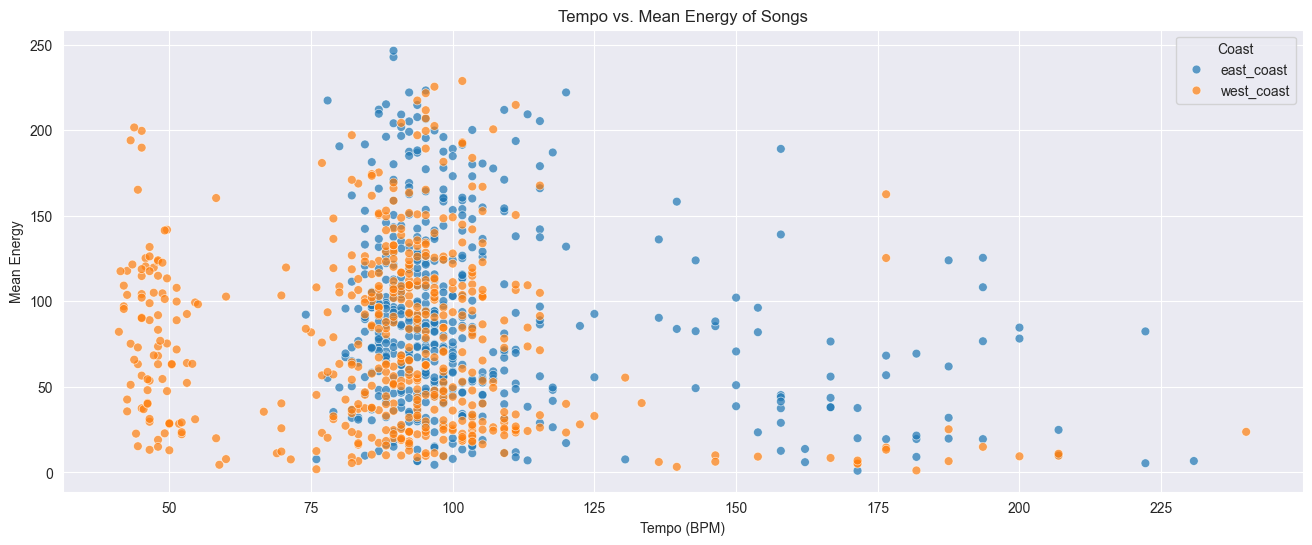

In [18]:
# Create a scatter plot
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x='Tempo1', y='Mean Energy', hue='Coast', marker='o', s=40, alpha=0.7)
plt.title('Tempo vs. Mean Energy of Songs')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Mean Energy')

# Show the plot
plt.show()

<b>Compare tempo with mean energy of the different artsits</b>

In [19]:
def plot_filtered_data_by_year_range(start_year, end_year):
    # Filter the DataFrame for songs released within the selected year range
    filtered_df = df[(df['Release_Year'] >= start_year) & (df['Release_Year'] <= end_year)]

    # Group by 'Artist' and 'Coast', calculate the mean
    artist_means = filtered_df.groupby(['Artist', 'Coast']).agg({'Tempo1': 'mean', 'Mean Energy': 'mean'}).reset_index()

    # Create a scatter plot using Plotly Express
    fig = px.scatter(artist_means, x='Tempo1', y='Mean Energy', color='Coast',
                     hover_name='Artist', size='Mean Energy', size_max=15,
                     labels={"Tempo1": "Mean Tempo (BPM)", "Mean Energy": "Mean Energy"})

    fig.update_layout(title=f'Mean Tempo vs. Mean Energy by Artist (Years {start_year} to {end_year})',
                      xaxis_title='Mean Tempo (BPM)',
                      yaxis_title='Mean Energy',
                      legend_title='Coast')
    fig.show()

In [20]:
only_tempo_and_energy = df[['Artist', 'Coast', 'Tempo1', 'Tempo2', 'Mean Energy', 'Release_Year']]

In [ ]:
import plotly.express as px
from ipywidgets import interact, widgets

years = sorted(only_tempo_and_energy['Release_Year'].unique())
start_year_widget = widgets.IntSlider(min=min(years), max=max(years), value=min(years), description='Start Year:')
end_year_widget = widgets.IntSlider(min=min(years), max=max(years), value=max(years), description='End Year:')

ui = widgets.HBox([start_year_widget, end_year_widget])

def update_range(*args):
    end_year_widget.min = start_year_widget.value  # Ensure end year is always >= start year

start_year_widget.observe(update_range, 'value')

interact(plot_filtered_data_by_year_range, start_year=start_year_widget, end_year=end_year_widget)

interactive(children=(IntSlider(value=1987, description='Start Year:', max=1998, min=1987), IntSlider(value=19…

<function __main__.plot_filtered_data_by_year_range(start_year, end_year)>

<b>This is just the regular, not interactive plot</b>

In [22]:
artist_means = only_tempo_and_energy.groupby(['Artist', 'Coast']).mean().reset_index()

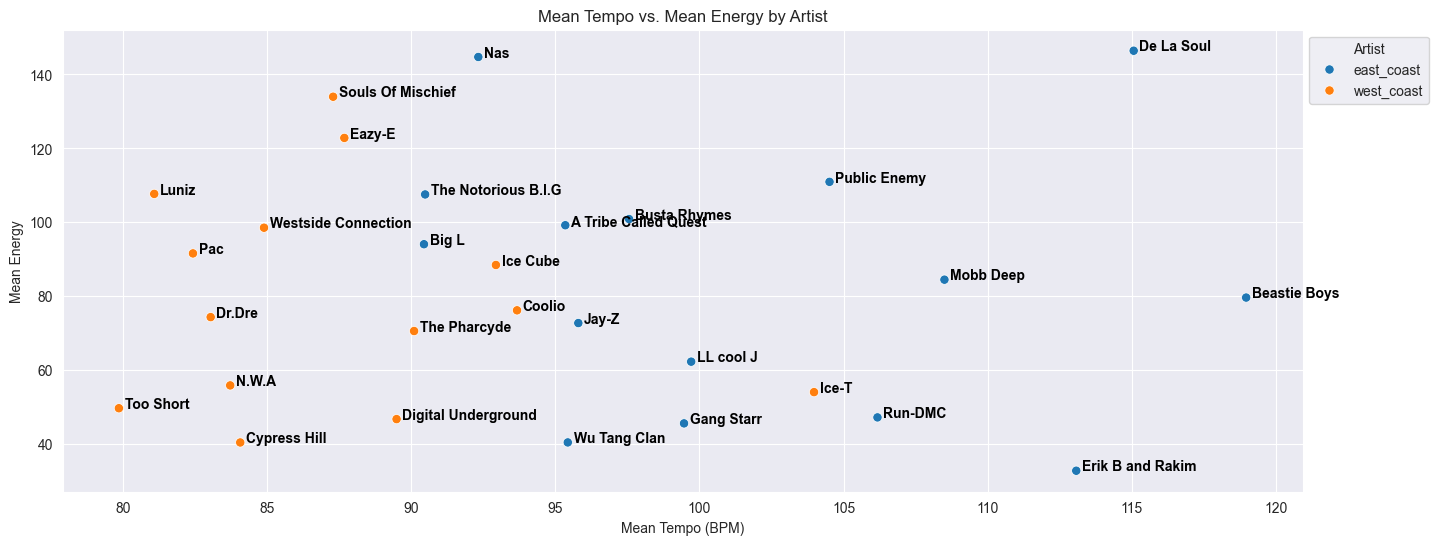

In [23]:
# Create a scatter plot
plt.figure(figsize=(16, 6))
scatter = sns.scatterplot(data=artist_means, x='Tempo1', y='Mean Energy', hue='Coast', s=45)
plt.title('Mean Tempo vs. Mean Energy by Artist')
plt.xlabel('Mean Tempo (BPM)')
plt.ylabel('Mean Energy')

# Adding labels for each point
for line in range(0, artist_means.shape[0]):
    scatter.text(artist_means['Tempo1'][line]+0.2, artist_means['Mean Energy'][line], artist_means.Artist[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

# Place the legend outside the plot
plt.legend(title='Artist', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [27]:
# Apply this function to the 'Local Tempos' column
df['Local Tempos'] = df['Local Tempos'].apply(convert_tempo)
df['Mean Tempo'] = df['Local Tempos'].apply(np.mean)
df['Tempo Std Dev'] = df['Local Tempos'].apply(np.std)

Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.
Cannot convert '...' to float.


In [28]:
df_tempo_variability = df[['Artist', 'Tempo1', 'Local Tempos', 'Coast']]

In [29]:
df_tempo_variability['CV'] = df_tempo_variability['Local Tempos'].apply(lambda tempos: np.std(tempos) / np.mean(tempos) if np.mean(tempos) > 0 else 0)

/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/ipykernel_26689/3935435387.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
df_agg = df_tempo_variability.groupby('Artist').agg({'CV': 'mean', 'Coast': 'first'}).reset_index()
df_agg = df_agg.sort_values('CV', ascending=True)

In [31]:
coast_colors = {
    'east_coast': 'blue',
    'west_coast': 'red'
}

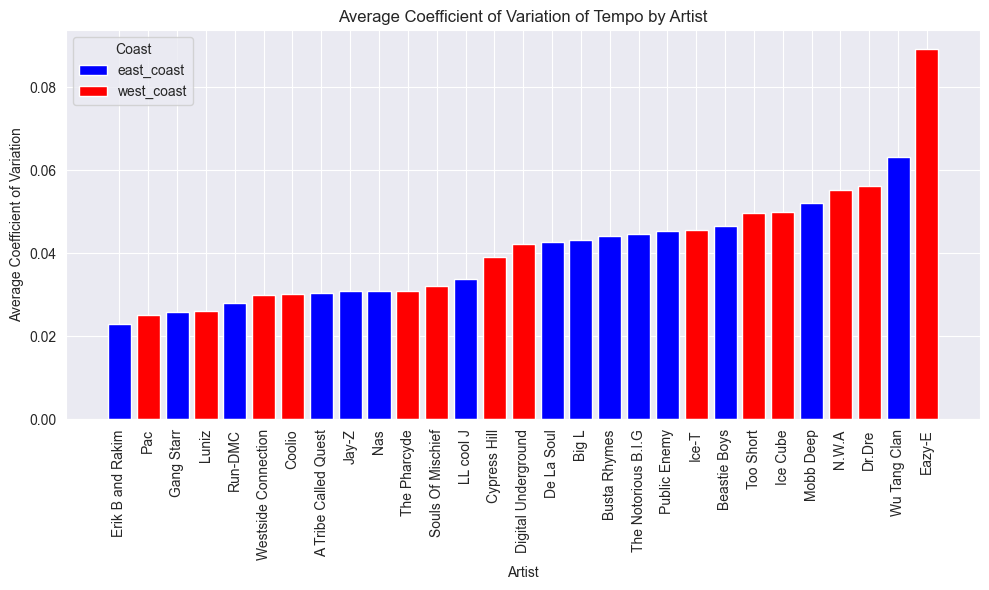

In [32]:
df_agg['Color'] = df_agg['Coast'].map(coast_colors)

# Plotting
plt.figure(figsize=(10, 6))
for _, row in df_agg.iterrows():
    plt.bar(row['Artist'], row['CV'], color=row['Color'], label=row['Coast'])

# Create a legend for the colors, but avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Eliminates duplicate labels
plt.legend(by_label.values(), by_label.keys(), title="Coast")

plt.title('Average Coefficient of Variation of Tempo by Artist')
plt.xlabel('Artist')
plt.ylabel('Average Coefficient of Variation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()